shape: torch.Size([1, 100, 587]) 	 sample rate: 44100


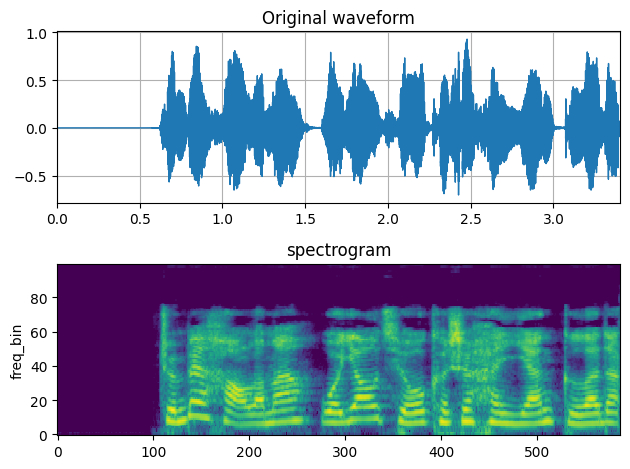

In [1]:
import librosa
import torch
import torchaudio
from matplotlib.patches import Rectangle
import torchcrepe
import matplotlib.pyplot as plt
from IPython.display import Audio


waveform, sample_rate = torchaudio.load("output.wav", normalize=True)
if sample_rate != 44100:
    waveform = torchaudio.functional.resample(waveform, sample_rate, 44100)
    sample_rate = 44100
    
n_fft = 1024
hop_length = 256
n_mels = 100
padding = 'center'
    
transform = torchaudio.transforms.MelSpectrogram(sample_rate,n_fft=n_fft,win_length=n_fft,hop_length=hop_length,n_mels=n_mels)
mel_specgram = transform(waveform)  # (channel, n_mels, time)
print(f"shape: {mel_specgram.shape} \t sample rate: {sample_rate}")

# 将Mel频谱图转换为numpy数组以便于绘图
mel_spectrogram_np = mel_specgram.numpy()

# 绘制Mel频谱图
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(mel_spectrogram_np[0], title="spectrogram", ax=axs[1])
fig.tight_layout()
Audio(waveform, rate=sample_rate)

In [2]:
audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram_np,sr=sample_rate,n_fft=n_fft,win_length=n_fft,hop_length=hop_length)
Audio(audio, rate=sample_rate)

In [4]:

from torchaudio import transforms
import torchaudio
from torchaudio.transforms import InverseMelScale, GriffinLim
from IPython.display import Audio

n_fft = 1024
n_stft = n_fft//2 + 1
n_mels = 100
hop_length = 256

waveform, sample_rate = torchaudio.load("output.wav", normalize=True)
# mel_spectrogram_transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels,hop_length=hop_length)
mel_spectrogram_transform = transforms.MelSpectrogram(n_mels=n_mels,sample_rate=sample_rate,n_fft=512,hop_length=256)
mel_spectrogram = mel_spectrogram_transform(waveform)
print(f"mel_spectrogram shape: {mel_spectrogram.shape}")


mel_spectrogram shape: torch.Size([1, 100, 320])


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (100) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


audio shape: (150058,)
mel shape: (128, 587)


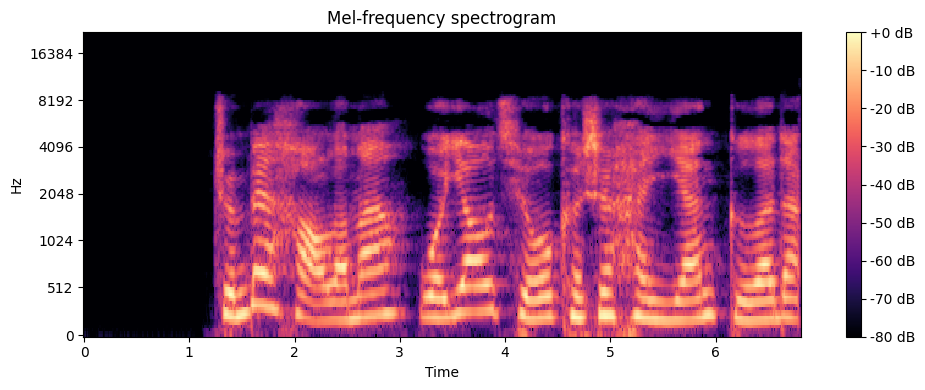

In [28]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 加载音频文件
audio_path = 'output.wav'
sample_rate = 44100
y, sr = librosa.load(audio_path,sr=sample_rate, mono=True)  # sr=None 保持原始采样率
print(f"audio shape: {y.shape}")

# 计算 Mel 频谱图
n_mels = 128
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,n_fft=1024,hop_length=256,)
print(f"mel shape: {S.shape}")

# 将 Mel 频谱图转换为分贝单位
S_dB = librosa.power_to_db(S, ref=np.max)

# 可视化 Mel 频谱图
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=sr/2)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

y_reconstructed = librosa.feature.inverse.mel_to_audio(S, sr=sr,n_fft=1024,hop_length=256,)
Audio(y_reconstructed, rate=sr)

In [27]:
import torch

from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/vocos-mel-24khz/config.yaml").eval()
model.load_state_dict(torch.load("/private/tmp/vocos-mel-24khz/pytorch_model.bin"))

rebuild_audio = torch.from_numpy(S)[None]
print(rebuild_audio.shape)

audio = model.decode(rebuild_audio,sr=sample_rate)
Audio(audio.squeeze(0).squeeze(0).numpy(),rate=sample_rate)

torch.Size([1, 100, 587])
